# Inspection of WEAVE first-light supercubes

## 1. Initialisation

### imports:

In [86]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as c

## 2. Read data

ESO SkyCalc <http://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC>

In [2]:
wavelength_SkyCalc, intensity_SkyCalc = np.loadtxt("ESO-SkyCalc_radiance.txt", unpack=True)

wavelength_SkyCalc *= 10  # nm -> Angstrom
intensity_SkyCalc *= 1e-8*(c.h*c.c/u.Angstrom).to_value(u.erg)/wavelength_SkyCalc  # ph/s/m^2/arcsec^2/micron -> erg/s/cm^2/arcsec^2/Angstrom

Datacubes:

In [3]:
hdu_red = fits.open('data/supercube_2963102-001.fit')
hdu_blue = fits.open('data/supercube_2963103-002.fit')

In [47]:
hdu_red_HR = fits.open('data/supercube_2963269.fit')
hdu_blue_HR = fits.open('data/supercube_2963270.fit')

In [4]:
wcs_red = WCS(hdu_red[1].header)
wavelength_red = wcs_red.spectral.pixel_to_world(np.arange(hdu_red[1].data.shape[0])).to_value(u.Angstrom)
sensitivity_function_red = hdu_red[5].data

wcs_blue = WCS(hdu_blue[1].header)
wavelength_blue = wcs_blue.spectral.pixel_to_world(np.arange(hdu_blue[1].data.shape[0])).to_value(u.Angstrom)
sensitivity_function_blue = hdu_blue[5].data

In [53]:
wcs_red_HR = WCS(hdu_red_HR[1].header)
wavelength_red_HR = wcs_red_HR.spectral.pixel_to_world(np.arange(hdu_red_HR[1].data.shape[0])).to_value(u.Angstrom)
sensitivity_function_red_HR = hdu_red_HR[5].data

wcs_blue_HR = WCS(hdu_blue_HR[1].header)
wavelength_blue_HR = wcs_blue_HR.spectral.pixel_to_world(np.arange(hdu_blue_HR[1].data.shape[0])).to_value(u.Angstrom)
sensitivity_function_blue_HR = hdu_blue_HR[5].data

In [108]:
ngc7328a_x, ngc7328a_y = wcs_red.celestial.world_to_pixel(SkyCoord('22h35m56.7s', '+33d57m56s'))
ngc7328b_x, ngc7328b_y = wcs_red.celestial.world_to_pixel(SkyCoord('22h35m58.4s', '+33d57m57s'))
print(ngc7328b_x, ngc7328b_y)

74.57375016492779 87.09633704640365


In [109]:
ngc7328a_x, ngc7328a_y = wcs_blue.celestial.world_to_pixel(SkyCoord('22h35m56.7s', '+33d57m56s'))
ngc7328b_x, ngc7328b_y = wcs_blue.celestial.world_to_pixel(SkyCoord('22h35m58.4s', '+33d57m57s'))
print(ngc7328b_x, ngc7328b_y)

74.57375016492779 87.09633704640365


In [110]:
ngc7328a_x_HR, ngc7328a_y_HR = wcs_red_HR.celestial.world_to_pixel(SkyCoord('22h35m56.7s', '+33d57m56s'))
ngc7328b_x_HR, ngc7328b_y_HR = wcs_red_HR.celestial.world_to_pixel(SkyCoord('22h35m58.4s', '+33d57m57s'))
print(ngc7328b_x_HR, ngc7328b_y_HR)

74.91733097448808 86.5883090411783


In [111]:
ngc7328a_x_HR, ngc7328a_y_HR = wcs_blue_HR.celestial.world_to_pixel(SkyCoord('22h35m56.7s', '+33d57m56s'))
ngc7328b_x_HR, ngc7328b_y_HR = wcs_blue_HR.celestial.world_to_pixel(SkyCoord('22h35m58.4s', '+33d57m57s'))
print(ngc7328b_x_HR, ngc7328b_y_HR)

74.91733097448808 86.5883090411783


### explore counts to define bright, medium, and faint regions:

In [5]:
mean_counts_red = np.nanmean(hdu_red[1].data, axis=0)  # same as hdu[6]
mean_sky_map_red = np.nanmean(hdu_red[3].data-hdu_red[1].data, axis=0)

mask_bright = mean_counts_red > mean_sky_map_red
mask_faint = (mean_counts_red > 0) & (mean_counts_red <= mean_sky_map_red)
mask_all = mean_counts_red > 0

In [30]:
mask_all_HR = hdu_red_HR[6].data > 0

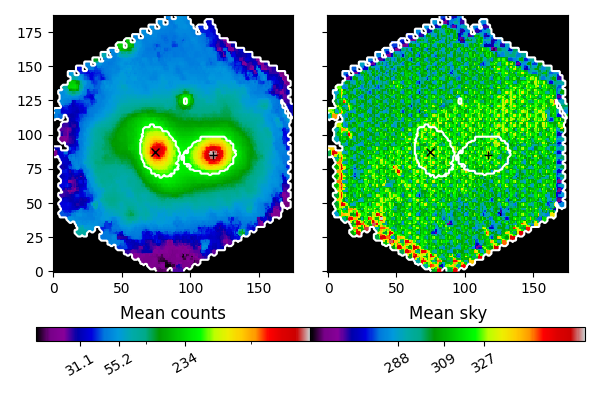

In [107]:
plt.close('counts')
fig = plt.figure('counts', figsize=(6, 4))
ax = fig.subplots(nrows=1, ncols=2, squeeze=False,
                  sharex=True, sharey=True,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)


def show_data(data, ax, title):
    p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral',
                   norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                  )
    ax.contour(mask_faint, levels=[0.5], colors=['w'])
    ax.plot(ngc7328a_x, ngc7328a_y, 'k+')
    ax.plot(ngc7328b_x, ngc7328b_y, 'kx')
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_title(title)
    cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)

show_data(mean_counts_red, ax[0, 0], 'Mean counts')
show_data(mean_sky_map_red, ax[0, 1], 'Mean sky')

plt.show()

### broadband colors:

In [7]:
class Filter(object):
    
    def __init__(self, filename, col_wavelength=0, col_response=1):
        self.wavelength, self.response = np.loadtxt(filename, usecols=(col_wavelength, col_response), unpack=True)        
        #self.norm_AB =  np.trapz(3631/3.34e4 * self.response/self.wavelength, self.wavelength)
        self.pivot_wavelength =  np.sqrt(
            np.trapz(self.response, self.wavelength) / np.trapz(self.response/self.wavelength**2, self.wavelength))
        
    def m_AB(self, wavelength, F_lambda):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(wavelength*F_lambda*response, wavelength) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

    def m_AB_cube(self, wavelength, F_lambda_cube):
        """F_lambda in erg/s/cm^2/AA"""
        response = np.interp(wavelength, self.wavelength, self.response)
        return -2.5*np.log10(
            np.trapz(F_lambda_cube*(wavelength*response)[:, np.newaxis, np.newaxis], wavelength, axis=0) / np.trapz(3631/3.34e4 * response/wavelength, wavelength))

g_filter = Filter('sdss-filters/g.dat', 0, 2)
r_filter = Filter('sdss-filters/r.dat', 0, 2)
i_filter = Filter('sdss-filters/i.dat', 0, 2)
z_filter = Filter('sdss-filters/z.dat', 0, 2)

### average SED within each region and broadband maps:

In [8]:
datacube = (hdu_red[3].data - hdu_red[1].data) * sensitivity_function_red[:, np.newaxis, np.newaxis]
sky_red = np.sum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)
datacube = (hdu_blue[3].data - hdu_blue[1].data) * sensitivity_function_blue[:, np.newaxis, np.newaxis]
sky_blue = np.sum(datacube*mask_all[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all)


In [54]:
datacube = (hdu_red_HR[3].data - hdu_red_HR[1].data) * sensitivity_function_red_HR[:, np.newaxis, np.newaxis]
sky_red_HR = np.sum(datacube*mask_all_HR[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all_HR)
datacube = (hdu_blue_HR[3].data - hdu_blue_HR[1].data) * sensitivity_function_blue_HR[:, np.newaxis, np.newaxis]
sky_blue_HR = np.sum(datacube*mask_all_HR[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_all_HR)

In [118]:
datacube = hdu_red[1].data * sensitivity_function_red[:, np.newaxis, np.newaxis]
SED_bright_red = np.sum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_faint_red = np.sum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
r_map = r_filter.m_AB_cube(wavelength_red, datacube)
i_map = i_filter.m_AB_cube(wavelength_red, datacube)
z_map = z_filter.m_AB_cube(wavelength_red, datacube)

/tmp/ipykernel_129647/409879002.py:18: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(
/tmp/ipykernel_129647/409879002.py:18: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(


In [119]:
SED_ngc7328a = np.mean(datacube[:, int(ngc7328a_y-15):int(ngc7328a_y+15), int(ngc7328a_x-15):int(ngc7328a_x+15)], axis=(1, 2))
SED_ngc7328b = np.mean(datacube[:, int(ngc7328b_y-15):int(ngc7328b_y+15), int(ngc7328b_x-15):int(ngc7328b_x+15)], axis=(1, 2))

In [10]:
datacube = hdu_blue[1].data * sensitivity_function_blue[:, np.newaxis, np.newaxis]
SED_bright_blue = np.sum(datacube*mask_bright[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_bright)
SED_faint_blue = np.sum(datacube*mask_faint[np.newaxis, :, :], axis=(1, 2))/np.count_nonzero(mask_faint)
g_map = g_filter.m_AB_cube(wavelength_blue, datacube)


/tmp/ipykernel_129647/409879002.py:18: RuntimeWarning: divide by zero encountered in log10
  return -2.5*np.log10(


/tmp/ipykernel_129647/2452682600.py:28: RuntimeWarning: invalid value encountered in subtract
  show_data(g_map-r_map, ax[1, 0], '(g-r)', cmap, 0.5, 1)
/tmp/ipykernel_129647/2452682600.py:29: RuntimeWarning: invalid value encountered in subtract
  show_data(i_map-z_map, ax[1, 1], '(i-z)', cmap, -.04, .14)
/tmp/ipykernel_129647/2452682600.py:30: RuntimeWarning: invalid value encountered in subtract
  show_data(r_map-z_map, ax[1, 2], '(r-z)', cmap, -.7, .5)
/tmp/ipykernel_129647/2452682600.py:31: RuntimeWarning: invalid value encountered in subtract
  show_data(r_map-i_map, ax[1, 3], '(r-i)', cmap, -.7, .5)


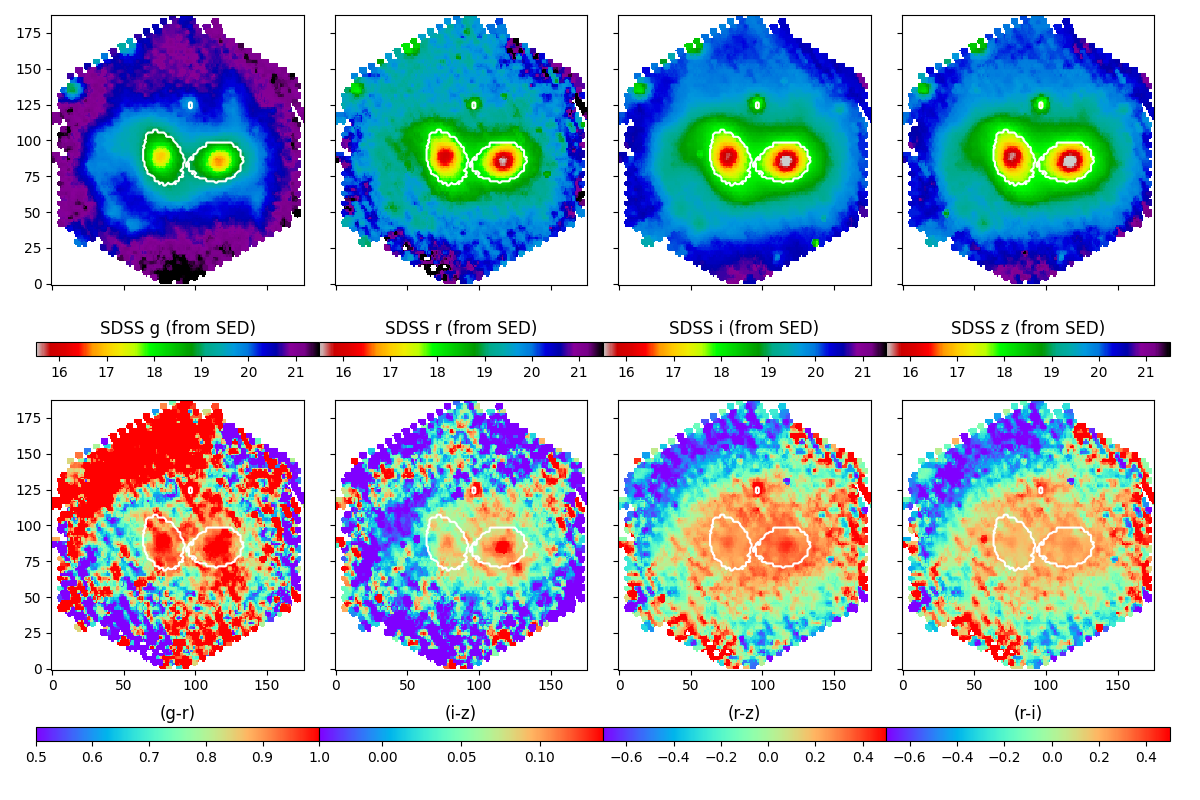

In [11]:
plt.close('broadband')
fig = plt.figure('broadband', figsize=(12, 8))
ax = fig.subplots(nrows=2, ncols=4, squeeze=False,
                  sharex=True, sharey=True,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)


def show_data(data, ax, title, cmap, vmin, vmax):
    #p0, p10, p50, p90, p100 = np.nanpercentile(data[data>0], [0, 10, 50, 90, 100])
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap=cmap, vmin=vmin, vmax=vmax,
#                       norm=colors.SymLogNorm(vmin=p0, vmax=p100, linthresh=p50-p0),
                  )
    ax.contour(mask_bright, levels=[0.5], colors=['w'])
    cb = fig.colorbar(im, ax=ax, orientation='horizontal')
    cb.ax.set_title(title)
    #cb.ax.set_xticks(ticks=[p10, p50, p90], labels=[f'{p10:.3g}', f'{p50:.3g}', f'{p90:.3g}'], rotation=30)

cmap = 'nipy_spectral_r'; vmin = 15.5; vmax = 21.5
show_data(g_map, ax[0, 0], 'SDSS g (from SED)', cmap, vmin, vmax)
show_data(r_map, ax[0, 1], 'SDSS r (from SED)', cmap, vmin, vmax)
show_data(i_map, ax[0, 2], 'SDSS i (from SED)', cmap, vmin, vmax)
show_data(z_map, ax[0, 3], 'SDSS z (from SED)', cmap, vmin, vmax)
cmap = 'rainbow'
show_data(g_map-r_map, ax[1, 0], '(g-r)', cmap, 0.5, 1)
show_data(i_map-z_map, ax[1, 1], '(i-z)', cmap, -.04, .14)
show_data(r_map-z_map, ax[1, 2], '(r-z)', cmap, -.7, .5)
show_data(r_map-i_map, ax[1, 3], '(r-i)', cmap, -.7, .5)

plt.show()

## 3. Spectrophotometric calibration:
### Compute correction:

In [12]:

def find_continuum(x, y, n=1):
    peaks = np.where(y > 0); xx, yy = x[peaks], y[peaks]
    peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
    xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
    while n > 1:
        peaks = np.where((yy[1:-1] <= yy[:-2]) & (yy[1:-1] <= yy[2:])); xx, yy = xx[1:-1][peaks], yy[1:-1][peaks]
        xx = xx[1:-1]; yy = np.median(np.vstack((yy[:-2], yy[1:-1], yy[2:])), axis=0)
        n -=1
    return xx, yy

wavelength_blue_continuum, sky_blue_continuum = find_continuum(wavelength_blue, sky_blue, 3);
wavelength_red_continuum, sky_red_continuum = find_continuum(wavelength_red, sky_red, 3);
wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum = find_continuum(wavelength_SkyCalc, intensity_SkyCalc, 2);
correction_blue = intensity_SkyCalc_continuum / np.interp(wavelength_SkyCalc_continuum, wavelength_blue_continuum, sky_blue_continuum)
correction_blue = np.interp(wavelength_blue, wavelength_SkyCalc_continuum, correction_blue)
correction_blue /= np.median(correction_blue)
correction_red = intensity_SkyCalc_continuum / np.interp(wavelength_SkyCalc_continuum, wavelength_red_continuum, sky_red_continuum)
correction_red = np.interp(wavelength_red, wavelength_SkyCalc_continuum, correction_red)
correction_red /= np.median(correction_red)


In [55]:
wavelength_red_HR_continuum, sky_red_HR_continuum = find_continuum(wavelength_red_HR, sky_red_HR, 3);
correction_red_HR =  np.interp(wavelength_red_HR_continuum, wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum) / sky_red_HR_continuum
correction_red_HR = np.interp(wavelength_red_HR, wavelength_red_HR_continuum, correction_red_HR)
correction_red_HR /= np.median(correction_red_HR)

wavelength_blue_HR_continuum, sky_blue_HR_continuum = find_continuum(wavelength_blue_HR, sky_blue_HR, 3);
correction_blue_HR =  np.interp(wavelength_blue_HR_continuum, wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum) / sky_blue_HR_continuum
correction_blue_HR = np.interp(wavelength_blue_HR, wavelength_blue_HR_continuum, correction_blue_HR)
correction_blue_HR /= np.median(correction_blue_HR)


In [13]:
g_bright = g_filter.m_AB(wavelength_blue, SED_bright_blue)
r_bright = r_filter.m_AB(wavelength_red, SED_bright_red)
i_bright = i_filter.m_AB(wavelength_red, SED_bright_red)
z_bright = z_filter.m_AB(wavelength_red, SED_bright_red)
g_faint = g_filter.m_AB(wavelength_blue, SED_faint_blue)
r_faint = r_filter.m_AB(wavelength_red, SED_faint_red)
i_faint = i_filter.m_AB(wavelength_red, SED_faint_red)
z_faint = z_filter.m_AB(wavelength_red, SED_faint_red)
g_sky = g_filter.m_AB(wavelength_blue, sky_blue)
r_sky = r_filter.m_AB(wavelength_red, sky_red)
i_sky = i_filter.m_AB(wavelength_red, sky_red)
z_sky = z_filter.m_AB(wavelength_red, sky_red)


In [14]:
lines = {}
lines['OII_3726'] = [3726.032, 3717.0, 3737.0]
lines['OII_3729'] = [3728.815, 3717.0, 3737.0]
lines['NeIII_3869'] = [3869.060, 3859.0, 3879.0]
lines['H_delta'] = [4101.734, 4092.0, 4111.0]
lines['H_gamma'] = [4340.464, 4330.0, 4350.0]
lines['OIII_4363'] = [4363.210, 4350.0, 4378.0]
lines['H_beta'] = [4861.325, 4851.0, 4871.0]
lines['OIII_4959'] = [4958.911, 4949.0, 4969.0]
lines['OIII_5007'] = [5006.843, 4997.0, 5017.0]
lines['HeI_5876'] = [5875.67, 5866.0, 5886.0]
lines['OI_6300'] = [6300.304, 6290.0, 6310.0]
lines['NII_6548'] = [6548.040, 6533.0, 6553.0]
lines['H_alpha'] = [6562.800, 6550., 6575., 6470., 6530., 6600., 6660.]
lines['NII_6584'] = [6583.460, 6573.0, 6593.0]
lines['SII_6717'] = [6716.440, 6704.0, 6724.0]
lines['SII_6731'] = [6730.810, 6724.0, 6744.0]
lines['CaT-a'] = [8500.36, np.nan, np.nan]
lines['CaT-b'] = [8544.44, np.nan, np.nan]
lines['CaT-c'] = [8664.52, np.nan, np.nan]

# NGC 7318
redshift_a = 6630/3e5
redshift_b = 5774/3e5

#wavelength_bins = np.array(lines['H_alpha'])
#indices_Ha_a = np.searchsorted(wavelength, wavelength_bins*(1+redshift_a))
#indices_Ha_b = np.searchsorted(wavelength, wavelength_bins*(1+redshift_b))


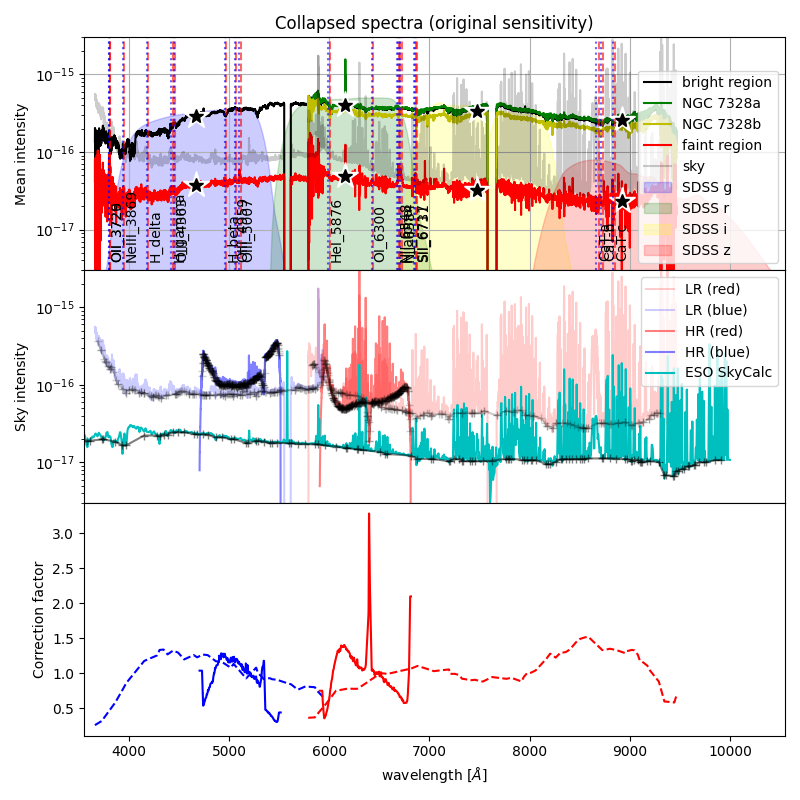

In [121]:
plt.close('spectra')
fig = plt.figure('spectra', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra (original sensitivity)')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/pixel?]')
ax[0, 0].set_ylabel(r'Mean intensity')

ax[0, 0].plot(wavelength_red, SED_bright_red, 'k-', label='bright region')
ax[0, 0].plot(wavelength_blue, SED_bright_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_ngc7328a, 'g-', label='NGC 7328a')
ax[0, 0].plot(wavelength_red, SED_ngc7328b, 'y-', label='NGC 7328b')

ax[0, 0].plot(wavelength_red, SED_faint_red, 'r-', label='faint region')
ax[0, 0].plot(wavelength_blue, SED_faint_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


ax[1, 0].set_ylabel(r'Sky intensity')
#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
#ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_red, sky_red, 'r-', alpha=.2, label='LR (red)')
ax[1, 0].plot(wavelength_blue, sky_blue, 'b-', alpha=.2, label='LR (blue)')
ax[1, 0].plot(wavelength_red_HR, sky_red_HR, 'r-', alpha=.5, label='HR (red)')
ax[1, 0].plot(wavelength_blue_HR, sky_blue_HR, 'b-', alpha=.5, label='HR (blue)')
ax[1, 0].plot(wavelength_SkyCalc, intensity_SkyCalc, 'c-', label='ESO SkyCalc')

ax[1, 0].plot(wavelength_SkyCalc_continuum, intensity_SkyCalc_continuum, 'k+-', alpha=.5)
ax[1, 0].plot(wavelength_blue_continuum, sky_blue_continuum, 'k+-', alpha=.2)
ax[1, 0].plot(wavelength_red_continuum, sky_red_continuum, 'k+-', alpha=.2)
ax[1, 0].plot(wavelength_red_HR_continuum, sky_red_HR_continuum, 'k+-', alpha=.2)
ax[1, 0].plot(wavelength_blue_HR_continuum, sky_blue_HR_continuum, 'k+-', alpha=.2)

ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Correction factor')

ax[2, 0].plot(wavelength_blue, correction_blue, 'b--')
ax[2, 0].plot(wavelength_red, correction_red, 'r--')
ax[2, 0].plot(wavelength_red_HR, correction_red_HR, 'r-')
ax[2, 0].plot(wavelength_blue_HR, correction_blue_HR, 'b-')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 10550)



ax[0, 0].grid()
plt.show()

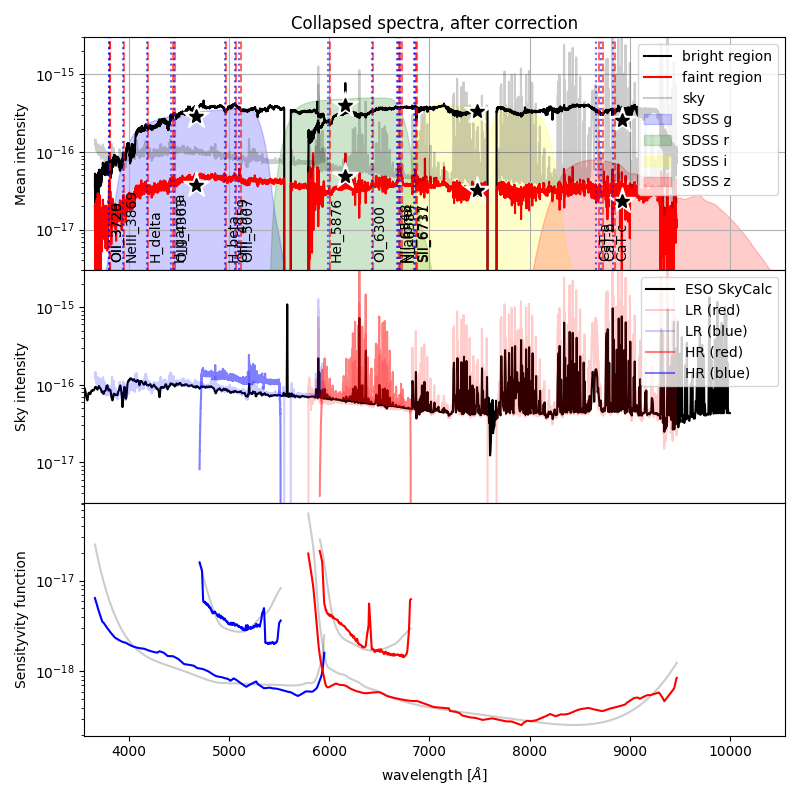

In [85]:
plt.close('corrected')
fig = plt.figure('corrected', figsize=(8, 8))
ax = fig.subplots(nrows=3, ncols=1, squeeze=False,
                  sharex=True, sharey=False,
                  gridspec_kw={'hspace': 0, 'wspace': 0}
                 )
fig.set_tight_layout(True)

ax[0, 0].set_title(r'Collapsed spectra, after correction')
ax[0, 0].set_ylabel(r'Mean intensity')
#ax[0, 0].set_ylabel(r'Mean intensity [erg/s/cm$^2/\AA$/... pixel?]')

ax[0, 0].plot(wavelength_red, SED_bright_red*correction_red, 'k-', label='bright region')
ax[0, 0].plot(wavelength_blue, SED_bright_blue*correction_blue, 'k-')

ax[0, 0].plot(wavelength_red, SED_faint_red*correction_red, 'r-', label='faint region')
ax[0, 0].plot(wavelength_blue, SED_faint_blue*correction_blue, 'r-')

ax[0, 0].plot(wavelength_red, sky_red*correction_red, 'k-', alpha=.2, label='sky')
ax[0, 0].plot(wavelength_blue, sky_blue*correction_blue, 'k-', alpha=.2)


ax[0, 0].fill_between(g_filter.wavelength, 1e-18, g_filter.response*1e-15, color='blue', alpha=.2, label='SDSS g')
ax[0, 0].fill_between(r_filter.wavelength, 1e-18, r_filter.response*1e-15, color='green', alpha=.2, label='SDSS r')
ax[0, 0].fill_between(i_filter.wavelength, 1e-18, i_filter.response*1e-15, color='yellow', alpha=.2, label='SDSS i')
ax[0, 0].fill_between(z_filter.wavelength, 1e-18, z_filter.response*1e-15, color='red', alpha=.2, label='SDSS z')

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_bright)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_bright)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_bright)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_bright)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(g_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*g_faint)/g_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(r_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*r_faint)/r_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(i_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*i_faint)/i_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'w*', ms=20)
ax[0, 0].plot(z_filter.pivot_wavelength, 3631/3.34e4 * 10**(-.4*z_faint)/z_filter.pivot_wavelength**2, 'k*', ms=10)

ax[0, 0].legend()

for line in lines:
    ax[0, 0].axvline(lines[line][0]*(1+redshift_a), c='r', alpha=.6, ls='--')
    ax[0, 0].axvline(lines[line][0]*(1+redshift_b), c='b', alpha=.6, ls=':')
    ymin, ymax = ax[0, 0].get_ylim()
    ax[0, 0].annotate(line, xy=(lines[line][0]*(1+redshift_a), .05), xycoords=('data', 'axes fraction'), rotation=90)
    #print(lines[line][0]*(1+redshift_a), ymin, line)


ax[0, -1].set_yscale('log')
ax[0, -1].set_ylim(3e-18, 3e-15)


ax[1, 0].set_ylabel(r'Sky intensity')
#ax[1, 0].set_ylabel(r'Sky intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')
#ax[1, 0].set_ylabel(r'Intensity [erg/s/cm$^2/\AA$/arcsec$^2$]')

ax[1, 0].plot(wavelength_SkyCalc, 4*intensity_SkyCalc, 'k-', label='ESO SkyCalc')
ax[1, 0].plot(wavelength_red, sky_red*correction_red, 'r-', alpha=.2, label='LR (red)')
ax[1, 0].plot(wavelength_blue, sky_blue*correction_blue, 'b-', alpha=.2, label='LR (blue)')
ax[1, 0].plot(wavelength_red_HR, sky_red_HR*correction_red_HR, 'r-', alpha=.5, label='HR (red)')
ax[1, 0].plot(wavelength_blue_HR, sky_blue_HR*correction_blue_HR, 'b-', alpha=.5, label='HR (blue)')


ax[1, 0].legend()
ax[1, -1].set_yscale('log')
ax[1, -1].set_ylim(3e-18, 3e-15)


ax[2, 0].set_ylabel(r'Sensityvity function')

ax[2, 0].plot(wavelength_blue, sensitivity_function_blue, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red, sensitivity_function_red, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue, sensitivity_function_blue*correction_blue, 'b-')
ax[2, 0].plot(wavelength_red, sensitivity_function_red*correction_red, 'r-')

ax[2, 0].plot(wavelength_blue_HR, sensitivity_function_blue_HR, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_red_HR, sensitivity_function_red_HR, 'k-', alpha=.2)
ax[2, 0].plot(wavelength_blue_HR, sensitivity_function_blue_HR*correction_blue_HR, 'b-')
ax[2, 0].plot(wavelength_red_HR, sensitivity_function_red_HR*correction_red_HR, 'r-')

ax[2, -1].set_yscale('log')


ax[-1, 0].set_xlabel(r'wavelength [$\AA$]')
ax[-1, -1].set_xlim(3550, 10550)



ax[0, 0].grid()
plt.show()

In [17]:
np.savetxt("sensitivity_function_blue.txt", np.vstack((wavelength_blue, sensitivity_function_blue*correction_blue)).T, fmt='%.2f %.4e')
np.savetxt("sensitivity_function_red.txt", np.vstack((wavelength_red, sensitivity_function_red*correction_red)).T, fmt='%.2f %.4e')


In [18]:
g_bright, r_bright, i_bright, z_bright

(18.0946452164363, 17.12119592802353, 16.912488368162002, 16.81341271887454)

In [19]:
g_faint, r_faint, i_faint, z_faint

(20.306533012015393, 19.432091057365696, 19.444883886510198, 19.41950642532482)

In [20]:
g_sky, r_sky, i_sky, z_sky

(19.42830929131876, 18.532854773719755, 18.165037565489563, 17.356555994331202)